In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
irisData = pd.read_csv("iris.data", skiprows=1, names = ["sepalLength", 
                                                            "sepalWidth", "petalLength", "petalWidth", "target"])
irisData.head()

,sepalLength,sepalWidth,petalLength,petalWidth,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [67]:
#Splitting Dataset
def split_DataSet(Dataset, size):
        msk = np.random.rand(len(Dataset))<size
        Data_train = Dataset[msk]
        Data_test = Dataset[~msk]
        return Data_train,Data_test
#Normalise Dataset
def normalize(x):
    return (x-min(x))/(max(x)-min(x))    
#convert any non-numeric values to numeric values
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))
    return df
#Calculate eucilidean distance
def distance(a, b):
    a = np.array(a) 
    b = np.array(b) 
    return np.linalg.norm(a - b)
#Get the nearest neighbours
def get_knn(xTest,target,ins,k,distance=distance):
    xdis = []
    for i in range(len(xTest)):        
        dist = distance(ins, xTest[i])
        xdis.append((xTest[i], dist, target[i]))        
    xdis.sort(key=lambda x: x[1])
    nn = xdis[:k]
    return nn
#Get the majority voting for the class of nearest neighbours
def vote_knn(nn):
    c = Counter()
    for nbr in nn:
        c[int(nbr[2])] += 1
    return c.most_common(1)[0][0]
#Crossfold validation 
def cv(xTrain, yTrain, nFolds):    
    indices = np.array(range(0, len(xTrain)))
    folds = np.array_split(indices, nFolds)
    #print("inside kfld")
    analysisMetricList = []    
    for i in range(0, len(folds)):
        validationSet = folds[i]
        trainSet = np.setdiff1d(indices, validationSet)        
        xtr = np.take(xTrain, trainSet, axis = 0)
        ytr = np.take(yTrain, trainSet, axis = 0)
        xte = np.take(xTrain, validationSet, axis = 0)
        yte = np.take(yTrain, validationSet, axis = 0) 
        pred = []
        for i in range(len(xte)):
            n = get_knn(xtr,ytr,xte[i], k ,distance=distance)
            pred.append(vote_knn(n))
        analysisMetricList.append(accuracy(yte,pred))     
    return analysisMetricList
#Test the quality of predictions
def accuracy(yTest,yPred):
    count = 0
    for index,i in enumerate(yTest):
        if i != yPred[index]:
            count += 1
    return (len(yTest) - count)/len(yTest)

In [46]:
iris_data=handle_non_numerical_data(irisData)
iris_data.head()

,sepalLength,sepalWidth,petalLength,petalWidth,target
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [47]:
trainSet, testSet = split_DataSet(iris_data, 0.7)
xTrain = trainSet.as_matrix(columns = ["sepalLength","sepalWidth", "petalLength", "petalWidth"])
xTest = testSet.as_matrix(columns = ["sepalLength","sepalWidth", "petalLength", "petalWidth"])
yTrain = trainSet["target"].as_matrix()
yTest = testSet["target"].as_matrix()
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(103, 4)
(47, 4)
(103,)
(47,)


C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [50]:
yPred=[]
for i in range(len(xTest)):
    neighbors = get_knn(xTrain,yTrain,xTest[i],4,distance=distance)
    yPred.append(vote_knn(neighbors))

In [51]:
accuracy(yTest,yPred)

0.9574468085106383

In [108]:
kGrid = range(7, 15)
acc = None
optimalK = None
accmetriclist = []
for k in kGrid:
    loss = cv(xTrain, yTrain, 4)
    #print(loss)
    accmetriclist.append(np.average(loss))
    #print(accmetriclist)
    if acc == None or acc < accmetriclist[-1]:
        acc = accmetriclist[-1]
        optimalK = k
print("\n optimal value of K is")
print(optimalK)


 optimal value of K is
9


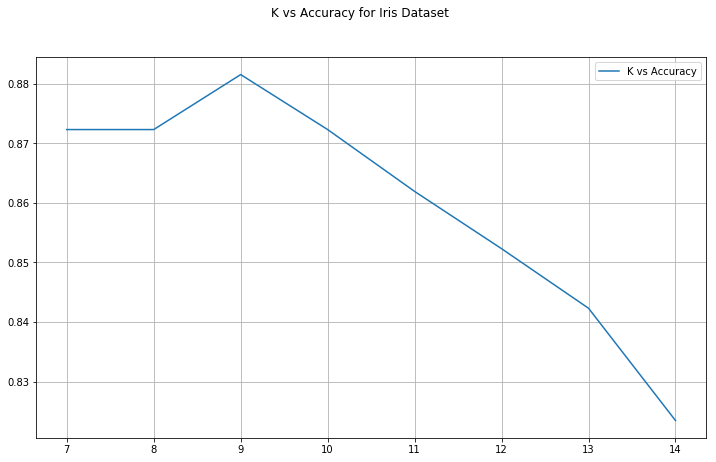

In [109]:
plt.figure(figsize=(12,7))
plt.suptitle("K vs Accuracy for Iris Dataset")
plt.plot(kGrid,accmetriclist, label = "K vs Accuracy")
plt.grid()
plt.legend()
plt.show()

In [65]:
winered_data = pd.read_csv('winequality-red.csv', delimiter = ';')
winered_data['volatile acidity'] = normalize(winered_data['volatile acidity'])
winered_data['chlorides'] = normalize(winered_data['chlorides'])
winered_data['density'] = normalize(winered_data['density'])
winered_data['alcohol'] = normalize(winered_data['alcohol'])

In [66]:
trainSet, testSet = split_DataSet(winered_data, 0.7)
xTrain2 = trainSet.as_matrix(columns = ['volatile acidity', 'chlorides', 'density', 'alcohol'])
xTest2 = testSet.as_matrix(columns = ['volatile acidity', 'chlorides', 'density', 'alcohol'])
#yTrain2 = trainSet['quality']
#yTest2 =  testSet['quality']
yTrain2 = trainSet.as_matrix(columns = ['quality'])
yTest2 = testSet.as_matrix(columns = ['quality']) 

C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [71]:
yPred2=[]
for i in range(len(xTest2)):
    neighbors = get_knn(xTrain2,yTrain2,xTest2[i],4,distance=distance)
    yPred2.append(vote_knn(neighbors))    

In [72]:
accuracy(yTest2,yPred2)

0.5638297872340425

In [74]:
kGrid = range(2, 9)
acc = None
optimalK = None
accmetriclist = []
for k in kGrid:
    loss = cv(xTrain2, yTrain2, 4)
    #print(loss)
    accmetriclist.append(np.average(loss))
    #print(accmetriclist)
    if acc == None or acc < accmetriclist[-1]:
        acc = accmetriclist[-1]
        optimalK = k
print("\n optimal value of K is")
print(optimalK)


 optimal value of K is
8


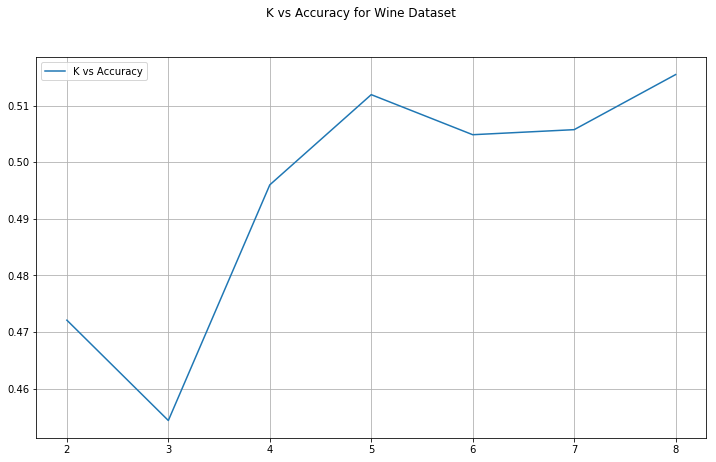

In [81]:
plt.figure(figsize=(12,7))
plt.suptitle("K vs Accuracy for Wine Dataset")
plt.plot(kGrid,accmetriclist, label = "K vs Accuracy")
plt.grid()
plt.legend()
plt.show()

In [82]:
#Compare KNN algorithm with Tree based method with SkLearn
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [83]:
clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit(xTrain, yTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
modelKNN = GridSearchCV(KNeighborsClassifier(), cv = 3, param_grid = {"n_neighbors" : range(6,15)})
modelKNN.fit(xTrain, yTrain)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(6, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [86]:
print("Best model " + str(modelKNN.best_score_))

Best model 0.970873786407767


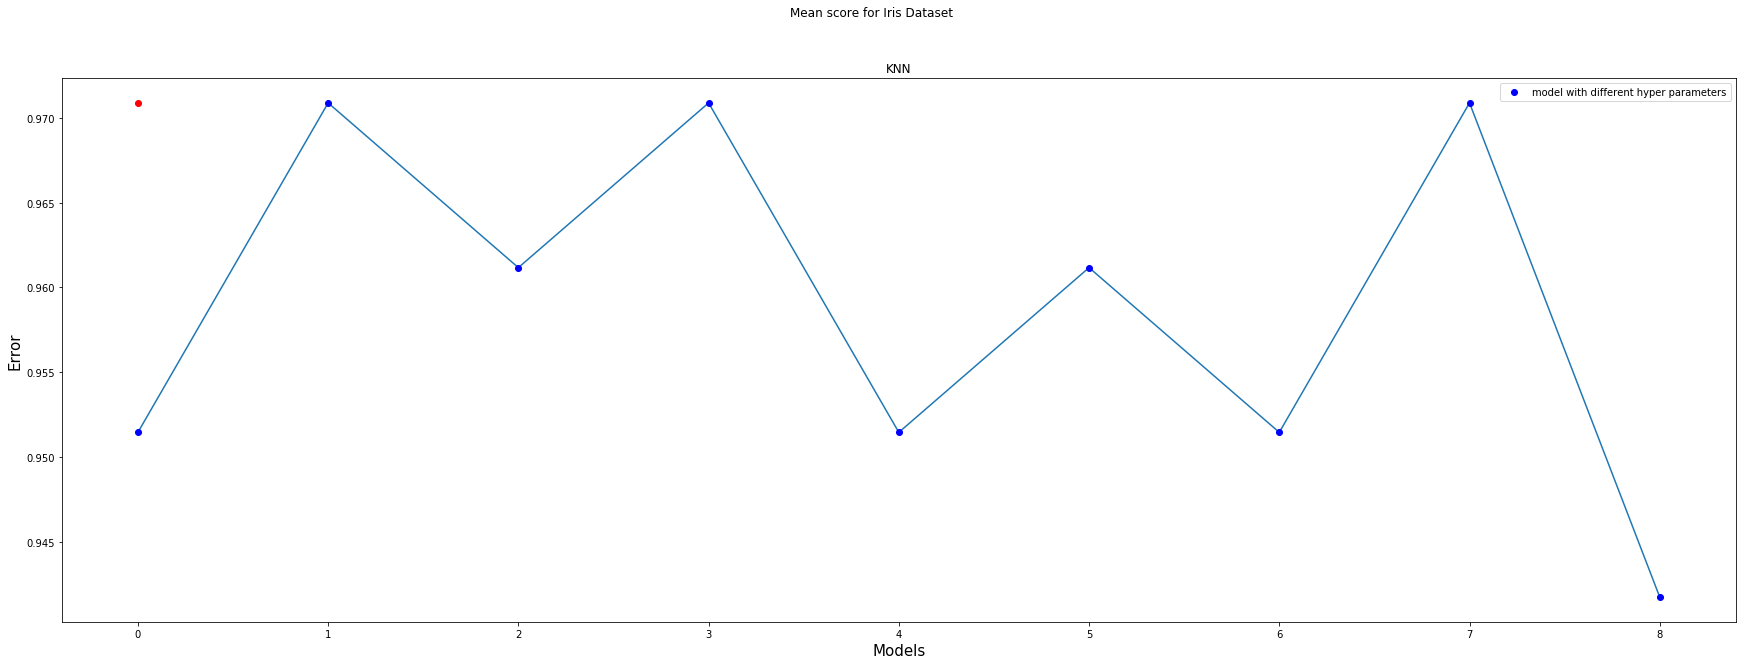

In [94]:
plt.figure(figsize = (30, 10))
plt.title("KNN")
plt.suptitle("Mean score for Iris Dataset")
plt.plot(modelKNN.cv_results_["mean_test_score"])
plt.plot(modelKNN.cv_results_["mean_test_score"], "bo", label = "model with different hyper parameters")
plt.plot(modelKNN.best_score_, "ro")
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Error', fontsize = 15)
plt.legend()
plt.show()

In [88]:
y_pred = modelKNN.predict(xTest)

In [89]:
modelKNN.score(xTest, yTest)

0.9361702127659575

In [90]:
from sklearn.tree import DecisionTreeClassifier

In [95]:
clf = DecisionTreeClassifier()
clf.fit(xTrain, yTrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [102]:
modelDT = GridSearchCV(DecisionTreeClassifier(), cv = 3, param_grid = {"max_depth": range(2,10), "min_samples_split" : [0.1,0.6] })
modelDT.fit(xTrain, yTrain)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [0.1, 0.6], 'max_depth': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [103]:
print("Best model " + str(modelDT.best_score_))

Best model 0.970873786407767


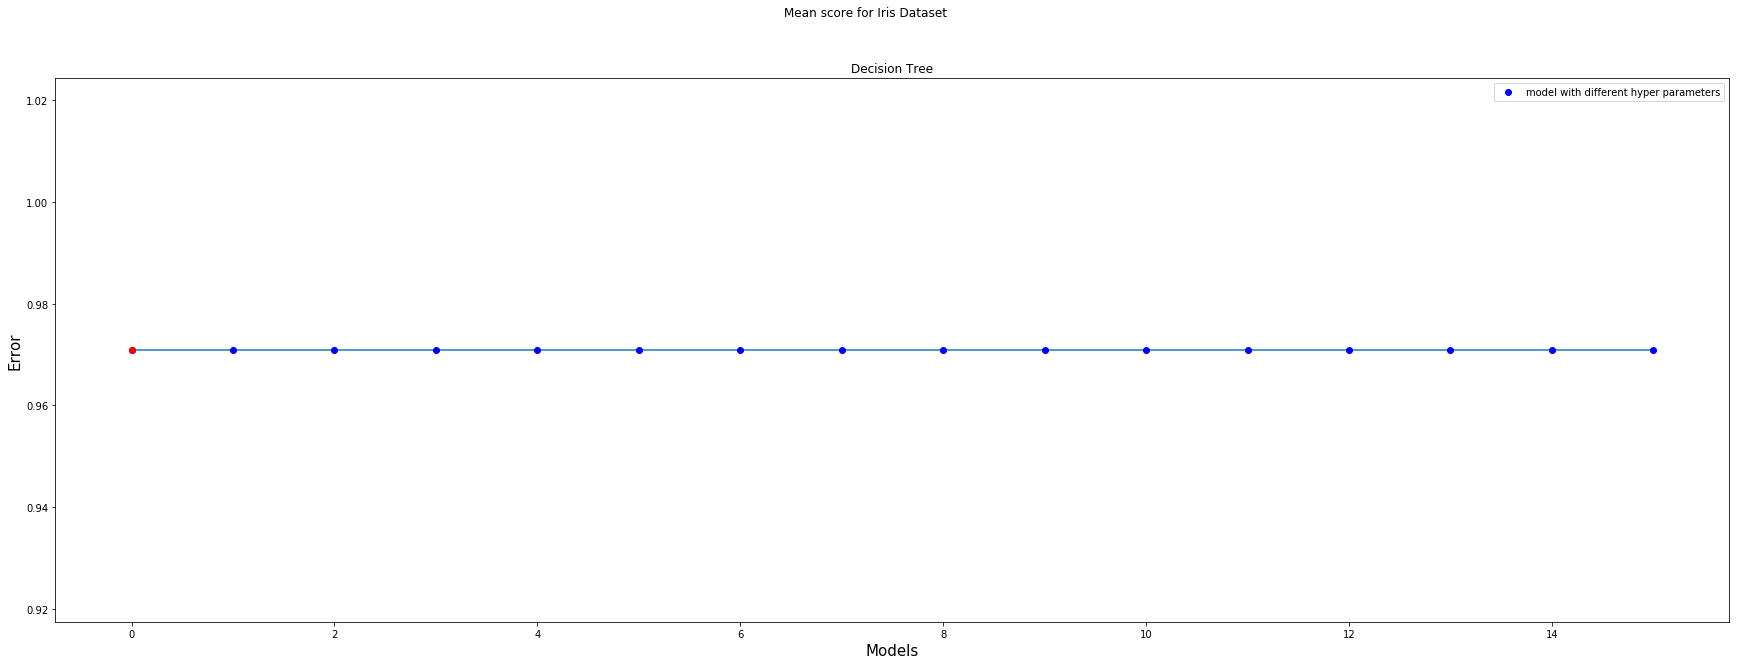

In [104]:
plt.figure(figsize = (30, 10))
plt.title("Decision Tree")
plt.suptitle("Mean score for Iris Dataset")
plt.plot(modelDT.cv_results_["mean_test_score"])
plt.plot(modelDT.cv_results_["mean_test_score"], "bo", label = "model with different hyper parameters")
plt.plot(modelDT.best_score_, "ro")
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Error', fontsize = 15)
plt.legend()
plt.show()

In [105]:
y_pred = modelDT.predict(xTest)

In [106]:
modelDT.score(xTest, yTest)

0.8936170212765957

In [110]:
trainSet, testSet = split_DataSet(winered_data, 0.7)
xTrain2 = trainSet.as_matrix(columns = ['volatile acidity', 'chlorides', 'density', 'alcohol'])
xTest2 = testSet.as_matrix(columns = ['volatile acidity', 'chlorides', 'density', 'alcohol'])
yTrain2 = trainSet['quality']
yTest2 =  testSet['quality']

C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\HP\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
modelKNN.fit(xTrain2, yTrain2)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(6, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [113]:
y_pred = modelKNN.predict(xTest2)

In [114]:
modelKNN.score(xTest2, yTest2)

0.558091286307054

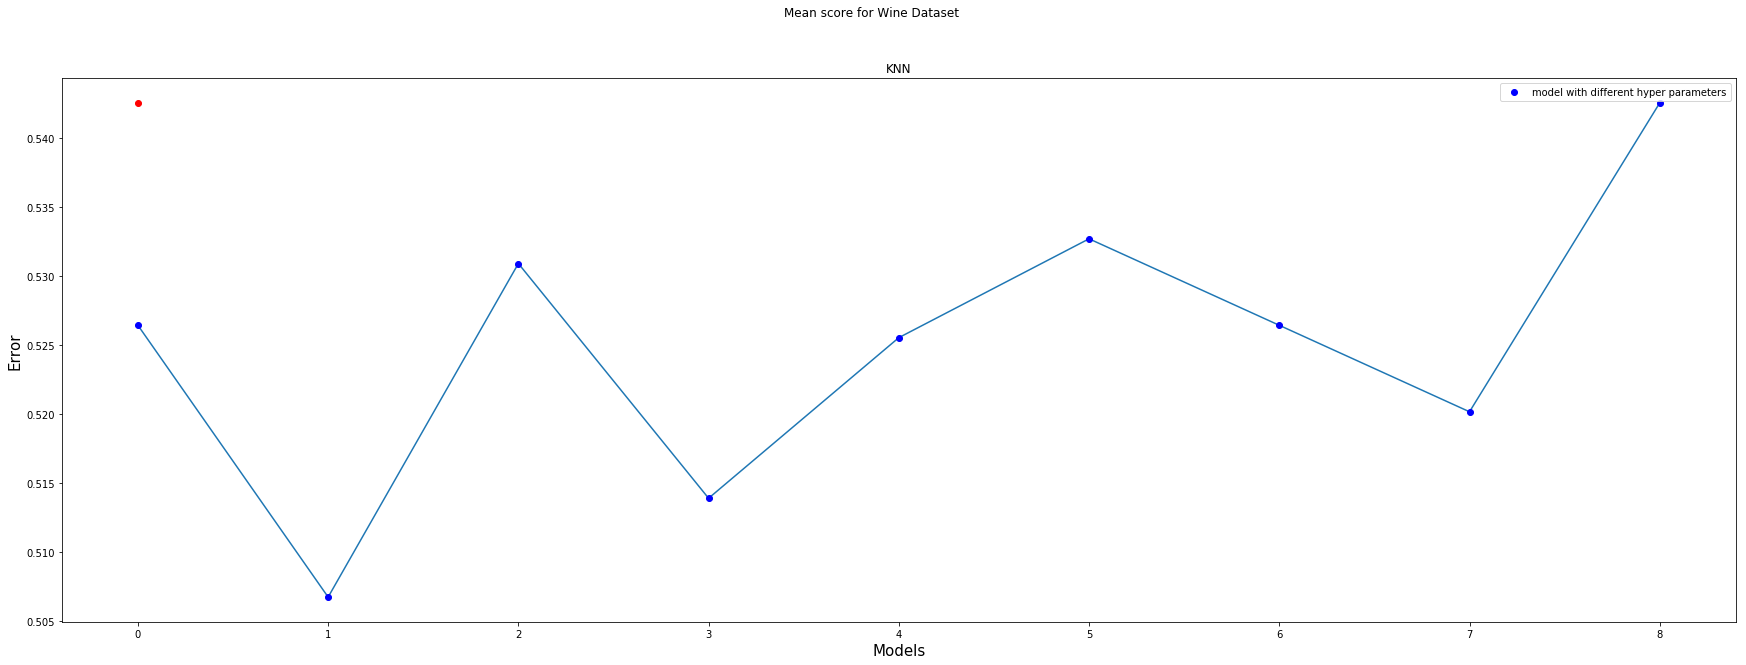

In [119]:
plt.figure(figsize = (30, 10))
plt.title("KNN")
plt.suptitle("Mean score for Wine Dataset")
plt.plot(modelKNN.cv_results_["mean_test_score"])
plt.plot(modelKNN.cv_results_["mean_test_score"], "bo", label = "model with different hyper parameters")
plt.plot(modelKNN.best_score_, "ro")
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Error', fontsize = 15)
plt.legend()
plt.show()

In [116]:
modelDT.fit(xTrain2, yTrain2)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [0.1, 0.6], 'max_depth': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [117]:
y_pred = modelDT.predict(xTest2)

In [118]:
modelDT.score(xTest2, yTest2)

0.5601659751037344

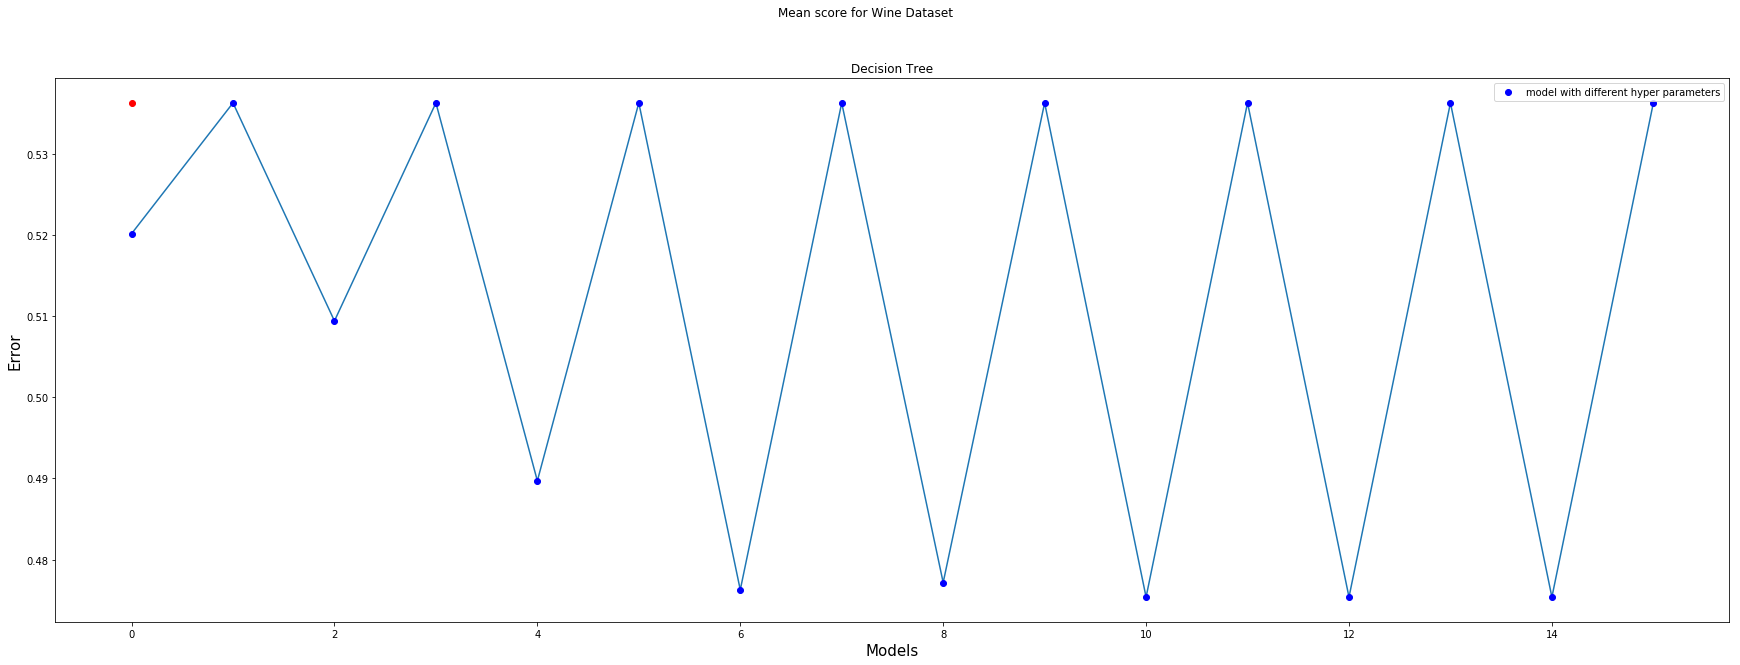

In [121]:
plt.figure(figsize = (30, 10))
plt.title("Decision Tree")
plt.suptitle("Mean score for Wine Dataset")
plt.plot(modelDT.cv_results_["mean_test_score"])
plt.plot(modelDT.cv_results_["mean_test_score"], "bo", label = "model with different hyper parameters")
plt.plot(modelDT.best_score_, "ro")
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Error', fontsize = 15)
plt.legend()
plt.show()